In [2]:
import pandas as pd
import ast
from Bio import SeqIO
from Bio import Entrez

In [4]:
dfc=pd.read_csv("SI tables/SI table 4.tsv",sep="\t",index_col=0)


In [5]:
genomes=list(set([x.split(";")[0] for x in dfc.q_name]))

In [4]:
to_write=[]
for index, row in dfc.iterrows():
    to_write.extend([row.q_name+";"+"Meta_"+str(x).replace(" ","") for x in ast.literal_eval(row.Meta_intervals)])
    to_write.extend([row.q_name+";"+"HGT_"+str(x).replace(" ","") for x in ast.literal_eval(row.HGT_intervals)])

In [62]:
##write a fasta with the portion of the nucleotide CDS corresponding to each hgt or metazoan interval
f=open("interval_nuc.fasta","w")
for xi in to_write:
    inter=ast.literal_eval(xi.split("_")[-1])
    start=inter[0]
    stop=inter[1]
    genome=xi.split(";")[0]
    gene=xi.split(";")[1]
    input_file = open(f"/n/netscratch/extavour_lab/Everyone/Rishabh/ncbi_dataset/data/{genome}/cds_from_genomic.fna")
    my_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
    
    xd=[x for x in my_dict.keys() if gene in x][0]
    seq=str(my_dict[xd].seq)
    
    seqs=[seq[i:i+3] for i in range(0, len(seq), 3)]
    
    mrna_inter="".join(seqs[start:stop])

    f.write(">"+xi)
    f.write("\n")
    f.write(mrna_inter)
    f.write("\n")
f.close()


In [8]:
input_file = open("interval_nuc.fasta")
inter_dict_nuc = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))

In [9]:
import pandas as pd
from Bio.Data import CodonTable

# Get the standard genetic code table
standard_table = CodonTable.unambiguous_dna_by_name["Standard"]
from Bio.Data import CodonTable

def get_amino_acid_codon_dict():
    # Initialize the standard codon table
    codon_table = CodonTable.unambiguous_dna_by_name["Standard"]

    # Initialize the dictionary to store amino acids and their codons
    amino_acid_codons = {}

    # Iterate through the codons and map them to their corresponding amino acids
    for codon, amino_acid in codon_table.forward_table.items():
        amino_acid_codons.setdefault(amino_acid, []).append(codon)

    return amino_acid_codons
amino_acid_codon_dict = get_amino_acid_codon_dict()


def get_codon_counts(gene_name, name=True):
    #returns a dataframe with codon use for a gene/interval in my_dict with name "gene_name"
    if name:
        gene_sequence=str(my_dict[gene_name].seq)
    else:
        gene_sequence=gene_name
 
    codon_table = {
        'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0, 'CTC': 0, 'CTA': 0, 'CTG': 0,
        'ATT': 0, 'ATC': 0, 'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0, 'GTG': 0,
        'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0, 'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0,
        'AAT': 0, 'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0, 'GAA': 0, 'GAG': 0,
        'TCT': 0, 'TCC': 0, 'TCA': 0, 'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
        'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0, 'GCC': 0, 'GCA': 0, 'GCG': 0,
        'TGT': 0, 'TGC': 0, 'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0, 'CGG': 0,
        'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0, 'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0,
    }

    gene_sequence = gene_sequence.upper().replace(" ", "")
    seq_length = len(gene_sequence)


    for i in range(0, seq_length, 3):
        codon = gene_sequence[i:i+3]
        if codon in codon_table:
            codon_table[codon] += 1

    codon_counts_df = pd.DataFrame.from_dict(codon_table, orient='index', columns=['Codon Count'])
    # codon_counts_df.index.name = 'Codon'
    # codon_counts_df.reset_index(inplace=True)
    # codon_counts_df=codon_counts_df.set_index("Codon")
    if len(gene_sequence)%3!=0:
        return codon_counts_df.fillna(pd.NA)
    return codon_counts_df
def get_fdict(series):
    #takes a series/dataframe where indices are codons and values are counts nd returns a series/df with amino acid counts
    aa_fdict={}
    for aa in amino_acid_codon_dict:
        cs=series.loc[amino_acid_codon_dict[aa]]
        fs=cs/cs.sum()
        for index,values in fs.items():
            aa_fdict[index]=values
    
    return pd.DataFrame.from_dict(aa_fdict,orient="index").sort_index()
def get_C(series):
    #determines the length correction factor 
    C=0
    for aa in amino_acid_codon_dict:
        cs=series.loc[amino_acid_codon_dict[aa]]
        if cs.sum()>0:
            C+=len(amino_acid_codon_dict[aa])-1

    C=C/np.sum(series)-.5
            
    
    return C
def get_MILC(gene):
    #calculates the MILC value for a gene/interval of name "name"
    o=get_codon_counts(gene,False).loc[:,"Codon Count"]
    ofreqs=get_fdict(o)

    dfri=pd.concat([efreqs,ofreqs,o],axis=1)
    dfri.columns=["Ef","Of","O"]
    dfri=dfri[dfri.Of!=0]

    MILC=2*np.sum(dfri.O*(np.log(dfri.Of)-np.log(dfri.Ef)))/np.sum(o)-get_C(o)
    return MILC

In [10]:
def sample_MILC_GC(length) :
    #performs one iteration of sampling from the cds fasta in my_dict
    #finds a random in-frame cds interval of length "length"
    #returns GC and MILC statistics 
    length=int(length)
    random_record="a"
    while len(random_record)%3!=0 or len(random_record)/3<length:
        random_record = str(my_dict[random.choice(list(my_dict.keys()))].seq)
    codon_seqs=[random_record[i:i+3] for i in range(0, len(random_record), 3)]

    start= random.randint(0, int(len(random_record)/3) - length)
    stop= start+ length
    
    codon_mrna_inter="".join(codon_seqs[start:stop])
    GC,GC1,GC2,GC3=GC123(codon_mrna_inter)
    return  get_MILC(codon_mrna_inter),GC,GC3

In [11]:
df_inter_results=pd.DataFrame(index=list(inter_dict_nuc.keys()),columns=["MILC","MILC_percen","GC", "GC_percen","GC3","GC3_percen"])

In [13]:
genome_set=set([x.split(";")[0] for x in to_write])

In [14]:
import multiprocessing as mp
import numpy as np
import random
from Bio.Seq import Seq
from Bio.SeqUtils import seq3
import random
from Bio.SeqUtils import GC123
from scipy.stats import percentileofscore
for genome in genome_set:
    input_file = open(f"/n/netscratch/extavour_lab/Everyone/Rishabh/ncbi_dataset/data/{genome}/cds_from_genomic.fna")
    my_dict = SeqIO.to_dict(SeqIO.parse(input_file, "fasta"))
    
    with mp.Pool(39) as p:
        results = p.map(get_codon_counts, my_dict.keys())
        
    dfr=pd.concat(results,axis=1)
    dfr.columns=my_dict.keys()
    dfr=dfr.T
    dfrTot=dfr.sum(axis=0)
    efreqs=get_fdict(dfrTot)
    
    for n in [x for x in inter_dict_nuc.keys() if genome in x]:
        
        with mp.Pool(39) as p:
            results = p.map(sample_MILC_GC, np.ones(10000)*(len(str(inter_dict_nuc[n].seq))/3))
        dfsim=pd.DataFrame(index=list(range(10000)),columns=["MILC","GC","GC3"])
        dfsim.loc[list(range(10000)),["MILC","GC","GC3"]]=results
        
        MILC_inter=get_MILC(str(inter_dict_nuc[n].seq))
        GC_inter,GC1_inter,GC2_inter,GC3_inter=GC123(str(inter_dict_nuc[n].seq))

        dataset=dfsim.MILC
        data_point = MILC_inter
        MILC_percen= percentileofscore(dataset, data_point)
        df_inter_results.loc[n,"MILC"]=MILC_inter
        df_inter_results.loc[n,"MILC_percen"]=MILC_percen
        
        dataset=dfsim.GC
        data_point = GC_inter
        GC_percen= percentileofscore(dataset, data_point)
        df_inter_results.loc[n,"GC"]=GC_inter
        df_inter_results.loc[n,"GC_percen"]=GC_percen
        
        dataset=dfsim.GC3
        data_point = GC3_inter
        GC3_percen= percentileofscore(dataset, data_point)
        df_inter_results.loc[n,"GC3"]=GC3_inter
        df_inter_results.loc[n,"GC3_percen"]=GC3_percen
    

In [21]:
df_inter_results['interval']=["'"+str(x.split("_")[-1])+"'" for x in df_inter_results.index]
df_inter_results['protein']=[str(x.split(";")[1]) for x in df_inter_results.index]
df_inter_results['annotation']=["'"+str(x.split(";")[-1].split("_")[0])+"'" for x in df_inter_results.index]
for index, row in df_inter_results.iterrows():
    df_inter_results.loc[index,"cluster"]=dfc[dfc.q_name.str.contains(row.protein)].index.values[0]

In [48]:
df_inter_results['interval']=["'"+str(x.split("_")[-1])+"'" for x in df_inter_results.index]
df_inter_results['protein']=[str(x.split(";")[1]) for x in df_inter_results.index]
df_inter_results['annotation']=["'"+str(x.split(";")[-1].split("_")[0])+"'" for x in df_inter_results.index]
for index, row in df_inter_results.iterrows():
    df_inter_results.loc[index,"cluster"]=dfc[dfc.representative_seq==row.protein].index.values[0]

In [23]:
df_inter_results.to_csv("SI tables/GC_codon.tsv",sep="\t")

In [5]:
from pathlib import Path
import sys
import matplotlib.pyplot as plt

import matplotlib.font_manager
from matplotlib.font_manager import FontProperties

import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
fpath = Path(mpl.get_data_path(), "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
plt.rcParams['figure.dpi'] = 300
font_path = "/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf"
font_manager.fontManager.addfont("/n/holylabs/LABS/extavour_lab/Users/rkapoor/envs/plot/fonts/arial.ttf")
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['svg.fonttype']='none'
import seaborn as sns

/n/home11/rkapoor/.conda/envs/rishabh/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
df_inter_results=pd.read_csv("SI tables/GC_codon.tsv",sep="\t",index_col=0)

/tmp/ipykernel_3408799/2825535384.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_inter_results, x='annotation', y="MILC_percen", jitter=True,ax=ax[0],palette=['darkorchid','gold'])
/tmp/ipykernel_3408799/2825535384.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_inter_results, x='annotation', y="GC_percen", jitter=True,ax=ax[1],palette=['darkorchid','gold'])


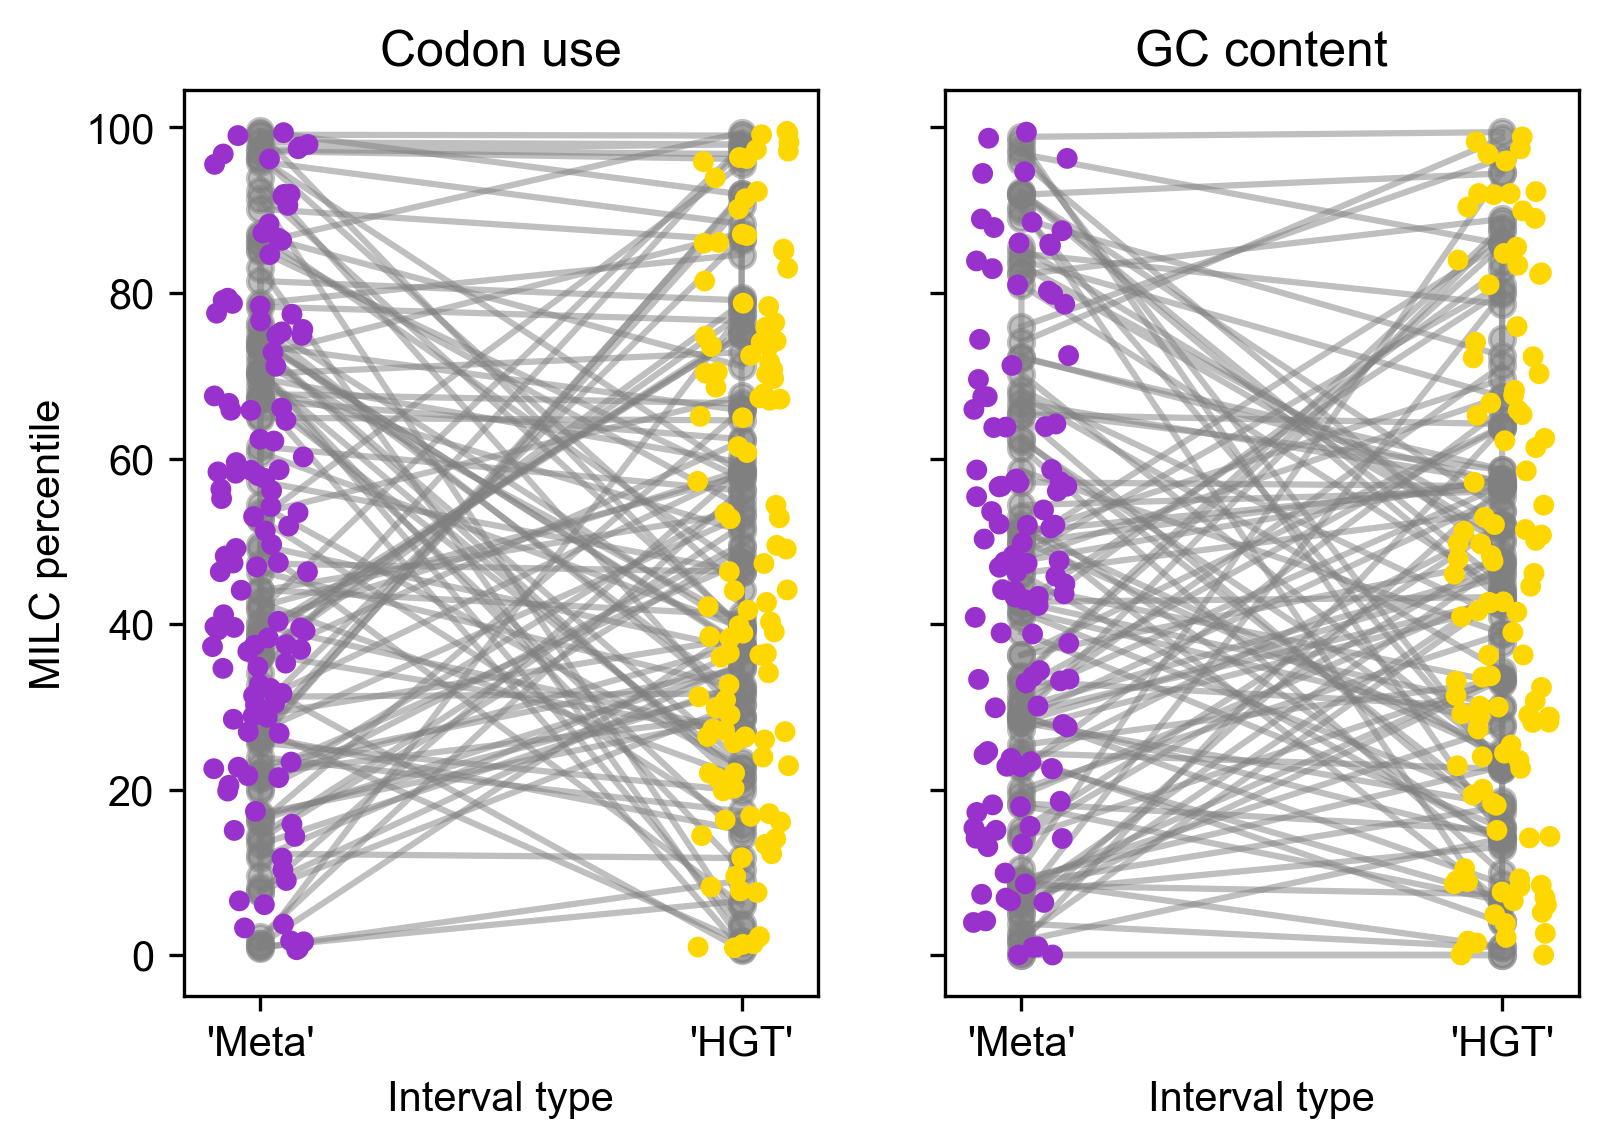

<Figure size 2400x1800 with 0 Axes>

In [20]:
df_inter_results = df_inter_results.sort_values(by='protein')

fig,ax=plt.subplots(1,2,sharey=True) 
sns.stripplot(data=df_inter_results, x='annotation', y="MILC_percen", jitter=True,ax=ax[0],palette=['darkorchid','gold'])
ax[0].set_xlabel("Interval type")
ax[0].set_ylabel("MILC percentile")
ax[0].set_title("Codon use")


gene_groups = df_inter_results.groupby('protein')
for _, group_data in gene_groups:
    x_coords = group_data['annotation'].map({"'HGT'": 0, "'Meta'": 1})
    y_coords = group_data['MILC_percen']
 
    ax[0].plot(x_coords, y_coords, marker='o', linestyle='-', color='gray',alpha=.5)



# Create the strip plot
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.stripplot(data=df_inter_results, x='annotation', y="GC_percen", jitter=True,ax=ax[1],palette=['darkorchid','gold'])
ax[1].set_xlabel("Interval type")
ax[1].set_ylabel("GC percentile")
ax[1].set_title("GC content")

gene_groups = df_inter_results.groupby('protein')
for _, group_data in gene_groups:
    x_coords = group_data['annotation'].map({"'HGT'": 0, "'Meta'": 1})
    y_coords = group_data['GC_percen']
    ax[1].plot(x_coords, y_coords, marker='o', linestyle='-', color='gray',alpha=.5)

plt.tight_layout()
fig.savefig("figures/gc_and_codon_use_interval.svg",format="svg")

plt.show()

Text(0, 0.5, 'Number of Chimeras')

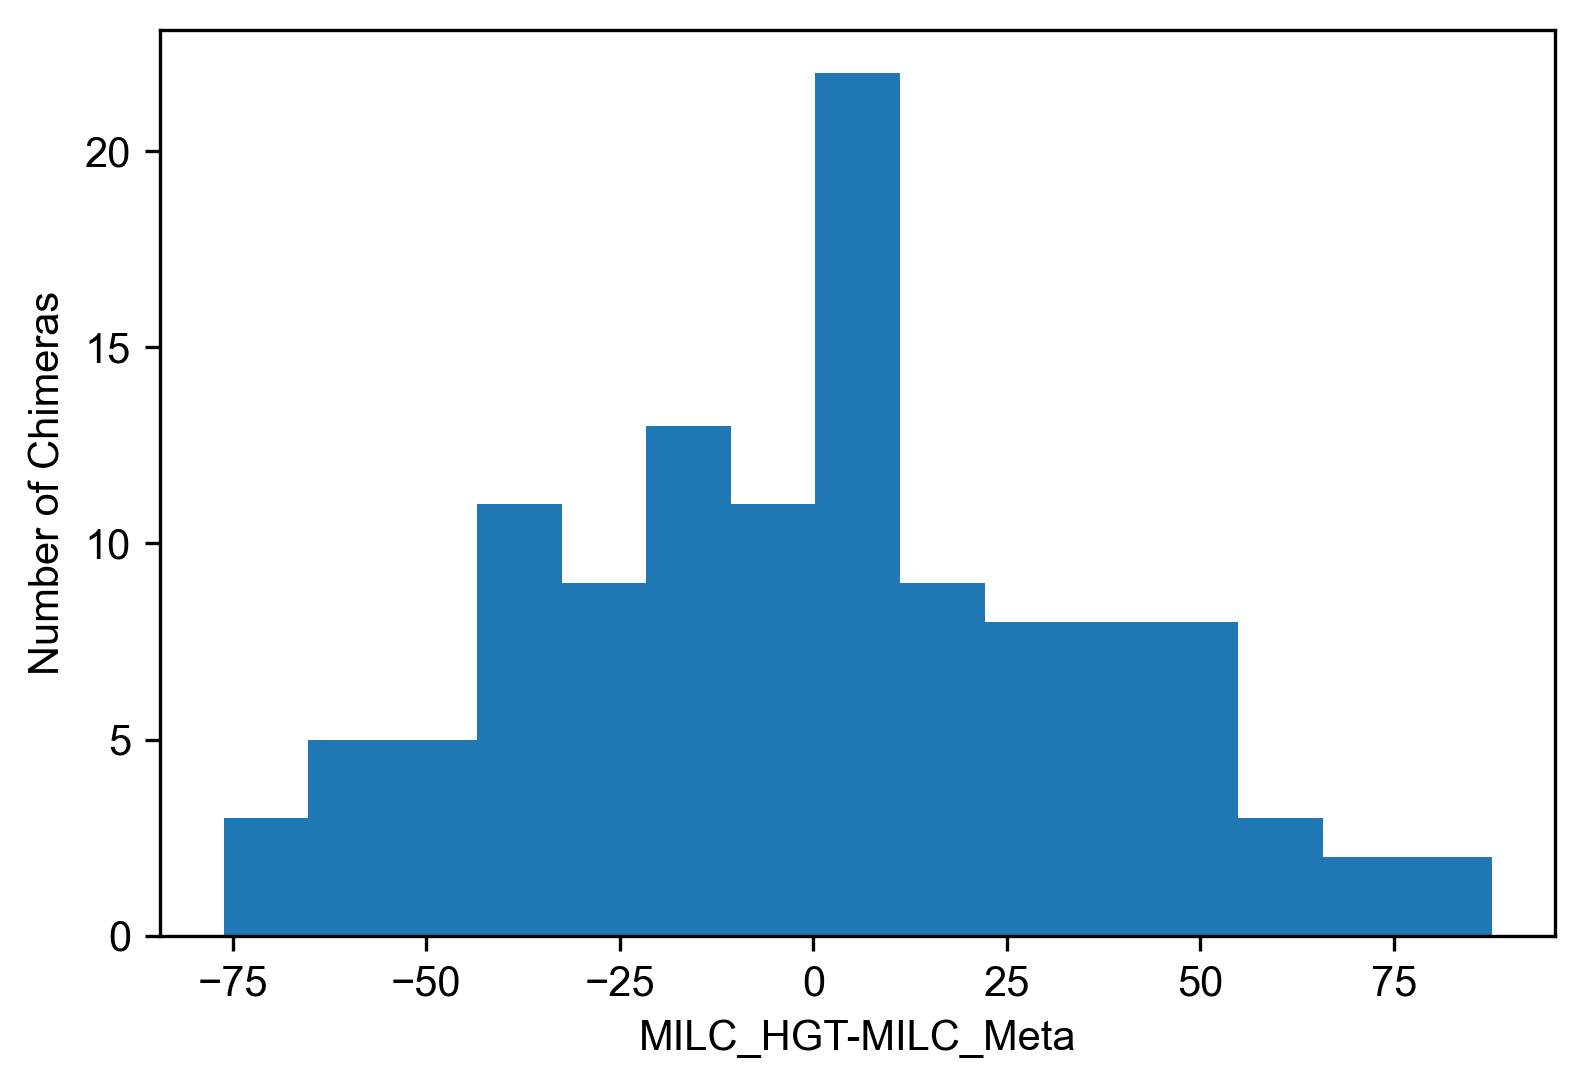

In [22]:
deltas=[]
gene_groups = df_inter_results.groupby('protein')
data1=[]
data2=[]
for _, group_data in gene_groups:
    x_coords = group_data['annotation'].map({"'HGT'": 0, "'Meta'": 1})
    y_coords = group_data['MILC_percen']
    dm={y:x for x,y in zip(list(x_coords),list(y_coords))}
    for HGT in [x for x in dm if dm[x]==0]:
        for Meta in [x for x in dm if dm[x]==1]:
            deltas.append(HGT-Meta)
            data1.append(HGT)
            data2.append(Meta)
    
plt.hist(deltas,bins=15)
plt.xlabel("MILC_HGT-MILC_Meta")
plt.ylabel("Number of Chimeras")

In [23]:
from scipy.stats import wilcoxon
statistic, p_value = wilcoxon(data1, data2)

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 3554.0
p-value: 0.9661567148557958


Text(0, 0.5, 'Number of Chimeras')

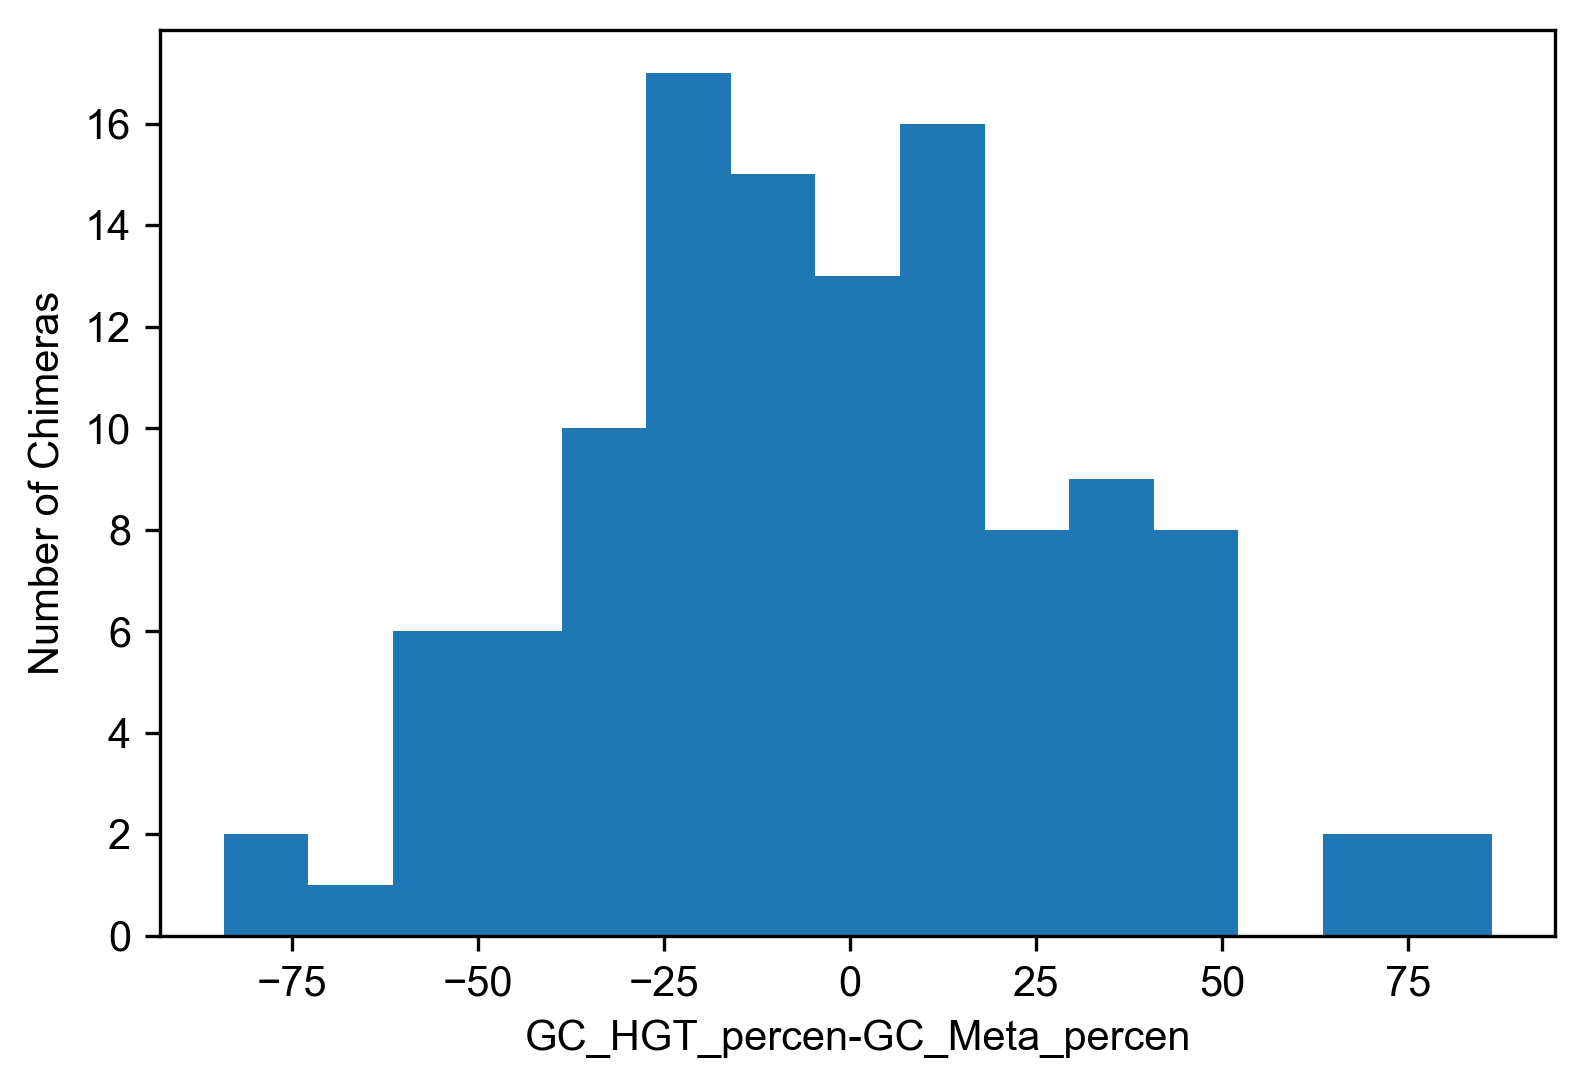

In [24]:
deltas=[]
gene_groups = df_inter_results.groupby('protein')
for _, group_data in gene_groups:
    x_coords = group_data['annotation'].map({"'HGT'": 0, "'Meta'": 1})
    y_coords = group_data['GC_percen']
    dm={y:x for x,y in zip(list(x_coords),list(y_coords))}
    for HGT in [x for x in dm if dm[x]==0]:
        for Meta in [x for x in dm if dm[x]==1]:
            deltas.append(HGT-Meta)
            data1.append(HGT)
            data2.append(Meta)
plt.hist(deltas,bins=15)
plt.xlabel("GC_HGT_percen-GC_Meta_percen")
plt.ylabel("Number of Chimeras")

In [25]:
from scipy.stats import wilcoxon
statistic, p_value = wilcoxon(data1, data2)

print("Wilcoxon statistic:", statistic)
print("p-value:", p_value)

Wilcoxon statistic: 13120.0
p-value: 0.5449607730998478
